<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/Staging-Notebooks/tumor_normal_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Comparing gene expression in tumor against gene expression in normal tissue
Author:  Fabian Seidl
Created: 2021-07-09
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/tumorvnormal.ipython
Purpose: To perform differential expression analysis comparing tumor to normal tissue
Notes: 
```

# Overview
This notebook is intended to demonstrate how to run a differential gene expression analysis between tumor and normal samples using GDC cancer data made available in BigQuery. We will be using the TCGA gene expression dataset in `isb-cgc-bq`, specifically the table `isb-cgc-bq.TCGA.mRNAseq_hg38_gdc_current`. This notebook is modeled to somewhat mirror the differential expression analysis found in Peng, et al. *Scientific Reports* 2015 (https://doi.org/10.1038/srep13413).

First we need to set up the environment and authenticate our session. This notebook will use both python to construct and run our SQL query and the Bioconductor R libraries `edgeR` and `DESeq2`.

In [ ]:
from google.colab import auth
import pandas_gbq
import pandas as pd
import numpy
import seaborn
from google.cloud import bigquery
%load_ext rpy2.ipython

bq_project='isb-cgc-etl'
auth.authenticate_user()
client = bigquery.Client(project=bq_project)
print('Authenticated')

Authenticated


# Finding all cases with data for both normal and tumor aliquots
Our first step is to join sample_type data to our RNA seq table and identify the cases in the RNA seq BigQuery table of choice that have data for both tumor and normal aliquots. To perform this operation we can write an SQL query which groups rows by case barcode and then use the `array_agg()` function to concatenate the `sample_type_name` field for each case. 


In [132]:
rna_table = "isb-cgc-bq.CPTAC.RNAseq_hg38_gdc_current"
sub_project = "TCGA-BRCA"

case_query = """
WITH rna as (
    SELECT 
      parent.*,
      case_table.sample_type_name
    FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current` parent
    JOIN `isb-cgc-bq.GDC_case_file_metadata.aliquot2caseIDmap_current` case_table
      ON case_table.case_barcode = parent.case_barcode 
      AND case_table.aliquot_barcode = parent.aliquot_barcode
    WHERE parent.gene_type = 'protein_coding'
    AND parent.project_short_name = '{1}'
),
cases as (
  SELECT case_barcode, agg FROM
      (SELECT 
        case_barcode, 
        array_agg(distinct sample_type_name) agg
      FROM rna
      GROUP BY case_barcode)
  WHERE array_length(agg) > 1
  AND ("Solid Tissue Normal" in UNNEST(agg))
  )""".format(rna_table, sub_project)

select_cases = """
SELECT * FROM cases
"""

query_job = client.query( case_query + select_cases )
# print( case_query + select_cases )
joined_data = query_job.result().to_dataframe()
joined_data.head(5)

,case_barcode,agg
0,TCGA-A7-A0DB,"[Primary Tumor, Solid Tissue Normal]"
1,TCGA-BH-A0H5,"[Solid Tissue Normal, Primary Tumor]"
2,TCGA-BH-A18P,"[Primary Tumor, Solid Tissue Normal]"
3,TCGA-E9-A1NG,"[Primary Tumor, Solid Tissue Normal]"
4,TCGA-E9-A1N4,"[Primary Tumor, Solid Tissue Normal]"


# Subsetting the gene set
Performing a comparison across all genes is outside of the scope of this notebook, so we will reduce our gene set to a more manageable size. A common metric to subset by is the variance of expression level. We can calculate this metric in an SQL query by grouping by the `Ensembl_gene_id_v` field and calculating the `VARIANCE()` of the counts field. We then order our results by this value and select the top 2000 genes.

In [133]:
expression_query = """,
mean_expr as (
  SELECT * FROM (
    SELECT  
      rna.Ensembl_gene_id_v, 
      VARIANCE(rna.HTSeq__FPKM) var_fpkm
    FROM rna 
    JOIN cases ON rna.case_barcode = cases.case_barcode 
    WHERE rna.sample_type_name = 'Solid Tissue Normal'
    GROUP BY rna.Ensembl_gene_id_v)
  ORDER BY var_fpkm DESC
  LIMIT 2000)""".format(rna_table)

select_genes = """
SELECT * FROM mean_expr
"""

query_job = client.query( case_query + expression_query + select_genes )
# print( case_query + expression_query + select_genes )
joined_data = query_job.result().to_dataframe()
joined_data.head(5)

,Ensembl_gene_id_v,var_fpkm
0,ENSG00000198886.2,2.097034e+07
1,ENSG00000198938.2,1.675706e+07
2,ENSG00000198840.2,1.462154e+07
3,ENSG00000198727.2,1.177244e+07
4,ENSG00000198899.2,1.158712e+07


# Joins are used to generate the table for analysis
To generate the final table we join the full RNA expression table back to the tables housing the list of cases as well as the list of genes. As both `edgeR` and `DESeq2` require counts as input the important fields we need are `case_barcode`, `aliquot_barcode`, `gene_name`, `sample_type_name`, and `HTSeq__Counts`.

In [134]:
final_join = """
SELECT rna.case_barcode, 
       rna.sample_barcode, 
       rna.aliquot_barcode, 
       rna.Ensembl_gene_id_v, 
       rna.gene_name, 
       rna.HTSeq__Counts,
       rna.sample_type_name,
FROM rna
  JOIN cases ON rna.case_barcode = cases.case_barcode
  JOIN mean_expr ON rna.Ensembl_gene_id_v = mean_expr.Ensembl_gene_id_v
WHERE rna.sample_type_name = 'Solid Tissue Normal' 
  OR rna.sample_type_name = 'Primary Tumor'
ORDER BY Ensembl_gene_id_v, case_barcode, aliquot_barcode 
""".format(rna_table)

query_job = client.query( case_query + expression_query + final_join )
# print( case_query + expression_query + final_join )
joined_data = query_job.result().to_dataframe()
joined_data.head(10)

,case_barcode,sample_barcode,aliquot_barcode,Ensembl_gene_id_v,gene_name,HTSeq__Counts,sample_type_name
0,TCGA-A7-A0CE,TCGA-A7-A0CE-01A,TCGA-A7-A0CE-01A-11R-A00Z-07,ENSG00000000005.5,TNMD,54,Primary Tumor
1,TCGA-A7-A0CE,TCGA-A7-A0CE-11A,TCGA-A7-A0CE-11A-21R-A089-07,ENSG00000000005.5,TNMD,320,Solid Tissue Normal
2,TCGA-A7-A0CH,TCGA-A7-A0CH-01A,TCGA-A7-A0CH-01A-21R-A00Z-07,ENSG00000000005.5,TNMD,0,Primary Tumor
3,TCGA-A7-A0CH,TCGA-A7-A0CH-11A,TCGA-A7-A0CH-11A-32R-A089-07,ENSG00000000005.5,TNMD,2116,Solid Tissue Normal
4,TCGA-A7-A0D9,TCGA-A7-A0D9-01A,TCGA-A7-A0D9-01A-31R-A056-07,ENSG00000000005.5,TNMD,73,Primary Tumor
5,TCGA-A7-A0D9,TCGA-A7-A0D9-11A,TCGA-A7-A0D9-11A-53R-A089-07,ENSG00000000005.5,TNMD,3616,Solid Tissue Normal
6,TCGA-A7-A0DB,TCGA-A7-A0DB-01A,TCGA-A7-A0DB-01A-11R-A00Z-07,ENSG00000000005.5,TNMD,68,Primary Tumor
7,TCGA-A7-A0DB,TCGA-A7-A0DB-01A,TCGA-A7-A0DB-01A-11R-A277-07,ENSG00000000005.5,TNMD,47,Primary Tumor
8,TCGA-A7-A0DB,TCGA-A7-A0DB-01C,TCGA-A7-A0DB-01C-02R-A277-07,ENSG00000000005.5,TNMD,29,Primary Tumor
9,TCGA-A7-A0DB,TCGA-A7-A0DB-11A,TCGA-A7-A0DB-11A-33R-A089-07,ENSG00000000005.5,TNMD,304,Solid Tissue Normal


# Moving the analysis to R
At this juncture we will move the analysis to R to take advantage of the standard Bioconductor differential expression packages. During the initial setup we loaded `rpy2` which allows us to execute cells in R using cell magic.

We will first need to install our R packages. Be aware that unfortunately this step can take upwards of 10 minutes and will request user input on whether to update dependencies, enter "a" for updating all. This behaviour can be common working in the cloud dependent on server availability and speed of interconnections. Executing this code in a Google Virtual Machine, especially one with the libraries pre-installed, is substantially faster.

In [ ]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("edgeR", "DESeq2"))

We can import the data frame into the R environment by with the `-i` flag in our `%%R` cell magic call and load the libraries we just installed.

In [135]:
%%R -i joined_data
library(DESeq2)
library(edgeR)
library(scales)

# Converting our longform data table into a count matrix
Both `edgeR` and `DESeq2` expect a data matrix of counts as an input where each column corresponds to a sample and each row to a gene. In our query we sorted our data frame by the `gene_name`, `case_barcode`, and `aliquot_barcode`. This allows us to split our data frame on gene_name and then `rbind()` the resulting count vectors into a matrix.

In [136]:
%%R
split_df <- split(joined_data, f=joined_data$gene_name)
str(split_df[c(1,2)]) # showing two data frames from our list output
expression_list <- lapply(split_df, function(df){df$HTSeq__Counts})
exp_matrix <- as.data.frame(Reduce(rbind, expression_list))

List of 2
 $ A2M :'data.frame':	229 obs. of  7 variables:
  ..$ case_barcode     : chr [1:229] "TCGA-A7-A0CE" "TCGA-A7-A0CE" "TCGA-A7-A0CH" "TCGA-A7-A0CH" ...
  ..$ sample_barcode   : chr [1:229] "TCGA-A7-A0CE-01A" "TCGA-A7-A0CE-11A" "TCGA-A7-A0CH-01A" "TCGA-A7-A0CH-11A" ...
  ..$ aliquot_barcode  : chr [1:229] "TCGA-A7-A0CE-01A-11R-A00Z-07" "TCGA-A7-A0CE-11A-21R-A089-07" "TCGA-A7-A0CH-01A-21R-A00Z-07" "TCGA-A7-A0CH-11A-32R-A089-07" ...
  ..$ Ensembl_gene_id_v: chr [1:229] "ENSG00000175899.13" "ENSG00000175899.13" "ENSG00000175899.13" "ENSG00000175899.13" ...
  ..$ gene_name        : chr [1:229] "A2M" "A2M" "A2M" "A2M" ...
  ..$ HTSeq__Counts    : int [1:229] 30166 136313 13326 93813 30214 98238 35509 23657 2728 90997 ...
  ..$ sample_type_name : chr [1:229] "Primary Tumor" "Solid Tissue Normal" "Primary Tumor" "Solid Tissue Normal" ...
 $ AAMP:'data.frame':	229 obs. of  7 variables:
  ..$ case_barcode     : chr [1:229] "TCGA-A7-A0CE" "TCGA-A7-A0CE" "TCGA-A7-A0CH" "TCGA-A7-A0CH" ...
  

We load our genes as rownames and the aliquot_barcodes as column names

In [137]:
%%R
colnames(exp_matrix) <- split_df[[1]]$aliquot_barcode
genes <- names(split_df)
rownames(exp_matrix) <- genes
str(exp_matrix, list.len=5)

'data.frame':	1999 obs. of  229 variables:
 $ TCGA-A7-A0CE-01A-11R-A00Z-07: int  30166 3082 10 1795 16922 1 7677 1680 6792 811 ...
 $ TCGA-A7-A0CE-11A-21R-A089-07: int  136313 9865 1649 7184 12509 6 5204 4220 3570 2923 ...
 $ TCGA-A7-A0CH-01A-21R-A00Z-07: int  13326 6227 2929 3450 5517 0 2824 493 3596 1132 ...
 $ TCGA-A7-A0CH-11A-32R-A089-07: int  93813 7889 8563 9372 17834 6 7747 17518 4243 4891 ...
 $ TCGA-A7-A0D9-01A-31R-A056-07: int  30214 7122 199 4325 3892 1 1894 4523 2477 621 ...
  [list output truncated]


We also need to generate vectors of which case each aliquot corresponds to as well as whether the aliquot is a tumor or normal sample. We can easily retrieve this information from our split data frame.

As a quick sanity check we can generate a heatmap to look at how our aliquots cluster and generate a histogram to compare the distributions of normal and tumor expression values.

 chr [1:229] "TCGA.A7.A0CE" "TCGA.A7.A0CE" "TCGA.A7.A0CH" "TCGA.A7.A0CH" ...
 chr [1:229] "Primary.Tumor" "Solid.Tissue.Normal" "Primary.Tumor" ...


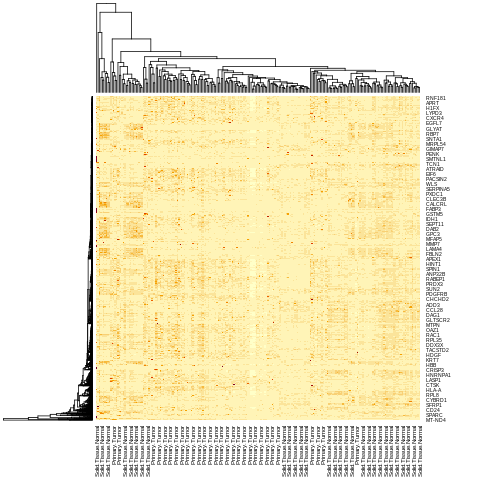

In [138]:
%%R
colnames(exp_matrix) <- split_df[[1]]$id
cases <- gsub('-', '.', split_df[[1]]$case_barcode)
str(cases)
sample_type <- gsub(' ', '.', split_df[[1]]$sample_type_name)
str(sample_type)
heatmap(as.matrix(exp_matrix), labCol=sample_type, rowv=NA, scale="row")

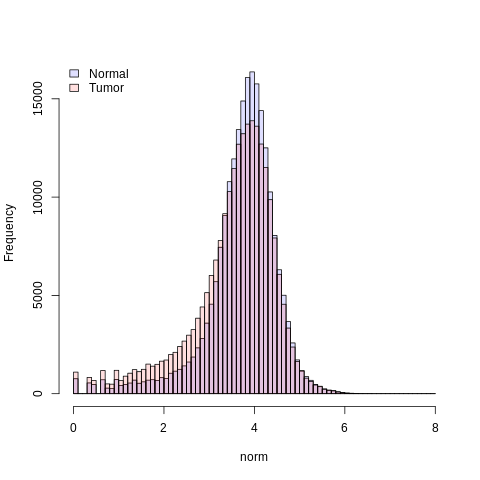

In [144]:
%%R
norm <- log10(unlist(exp_matrix[,which(sample_type == 'Solid.Tissue.Normal')]))
tumor <- log10(unlist(exp_matrix[,which(sample_type == 'Primary.Tumor')]))

p_norm <- hist(norm, breaks=seq(0,8,0.1), plot=0)
p_tumor <- hist(tumor, breaks=seq(0,8,0.1), plot=0)
plot( p_norm, col=rgb(0,0,1,1/8), xlim=c(0,8), xlab='log10(count)', main='')
plot( p_tumor, col=rgb(1,0,0,1/8), xlim=c(0,8), add=T)
legend("topright", legend=c("Normal", "Tumor"), fill=c(rgb(0,0,1,1/8), rgb(1,0,0,1/8)), bty="n") 

# Calculating differential expression using edgeR
We can now feed these data to edgeR, generate significance values of differential expression, and visualize the results using a scatterplot. Genes that fall below a 0.01 significance threshold are color coded red.

In [140]:
%%R
dge_obj <- DGEList(
             counts=exp_matrix, 
             lib.size=colSums(exp_matrix),
             samples=cases, 
             group=sample_type)
disp <- estimateDisp(dge_obj, method="pooled")
edgeR_test <- exactTest(disp)
results_df <- topTags(edgeR_test, nrow(exp_matrix))@.Data[[1]]
str(results_df)

R[write to console]: Using classic mode.



'data.frame':	1999 obs. of  4 variables:
 $ logFC : num  2.93 3.41 -3.43 3.42 2.34 ...
 $ logCPM: num  9.56 6.46 12.87 6.21 11.31 ...
 $ PValue: num  3.45e-118 9.57e-115 4.71e-113 1.65e-107 2.16e-106 ...
 $ FDR   : num  6.89e-115 9.56e-112 3.14e-110 8.24e-105 8.63e-104 ...


[1] 1570


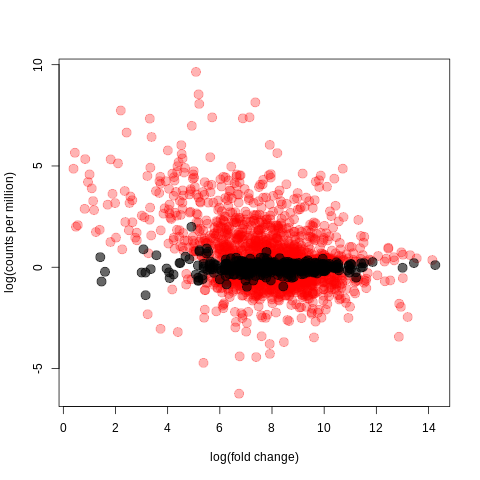

In [141]:
%%R
colors <- c(alpha('red', 0.3), alpha('black', 0.6))[(results_df$FDR > 0.01)+1]
plot(results_df$logCPM, results_df$logFC, 
     pch=19, cex=1.7, col=colors,
     xlab='log(fold change)', ylab='log(counts per million)')
sum(results_df$FDR <= 0.01)

# Or perform the same calcuations using DESeq2
As above we can perform comparisons using DESeq2 instead. We generate the expected input matrix and sample information data frame and run the model on our data.

In [142]:
%%R
col_info <- as.data.frame(cbind(cases, sample_type), stringAsFactors=TRUE)
deseq_obj <- DESeqDataSetFromMatrix( countData = exp_matrix, colData= col_info, design= ~ cases + sample_type)
deseq_output <- DESeq(deseq_obj, fitType='local')
summary(deseq_output)
deseq_results <- results(deseq_output)@listData

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: 16 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



We can once again visualize our results plotting mean expression against fold change.

[1] 1604


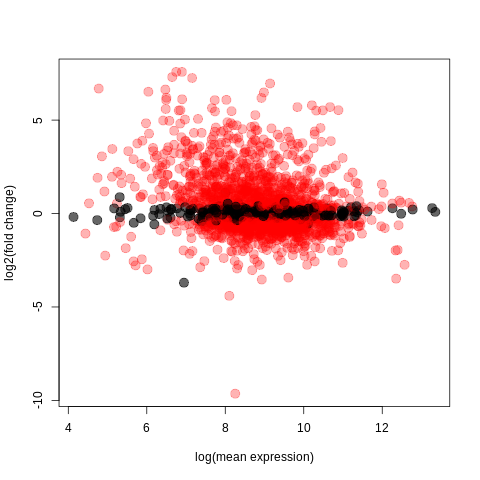

In [143]:
%%R
colors <- c(alpha('red', 0.3), alpha('black', 0.6))[(deseq_results$padj > 0.01)+1]
plot(log(deseq_results$baseMean), deseq_results$log2FoldChange, 
     pch=19, cex=1.7, col=colors,
     xlab='log(mean expression)', ylab='log2(fold change)')
sum(deseq_results$padj <= 0.01)

# Summary
It is quite simple to retrieve expression data from the GDC through the BQ ecosystem. These data can be subset and summarized easily via SQL queries and the results loaded into either R or Python for further analysis and visualization.